<a href="https://colab.research.google.com/github/brunoleme/Dimension_Reduction_and_Clustering/blob/main/Dimension_Reduction_and_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dependencies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import numpy as np
import itertools
import pandas as pd
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from PIL import Image
import random

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram

The data of this study is from my personal social network on Facebook, collected in 2014, through Facebook Graph API v1.1.

In [ ]:
with open('/content/drive/My Drive/Facebook_Data_Bruno_Leme/favorite_music.json', 'rb') as file:
    dict_friends_favorite_music = json.loads(file.read())

# **Data Prep**

Inspecting structure of the dictionary loaded from json file.

In [ ]:
[k for k in dict_friends_favorite_music][:10]

['data']

In [ ]:
[k for k in dict_friends_favorite_music['data']][:10]

[{'music': 'In Perpetuum, Maíra Guedes e os Baluartes, Aerosmith, Red Hot Chili Peppers, Metallica, Legião Urbana',
  'uid': 530759938},
 {'music': 'Bangalafumenga, Banda Vallente', 'uid': 531013568},
 {'music': '2 Chainz, Dee, Alana Bridgewater, Lil Wayne, R. Kelly, Wiz Khalifa, Wiz Khalifa voice (Okaaaayyyyyyyy!), Michael Jackson',
  'uid': 534275844},
 {'music': "Insta Vídeos, Arlindo Cruz, Móveis Coloniais de Acaju, Videos Engraçados Para Rir, Beyoncé, Rodrigo Ramos, Mc Menor Do Chapa, Projota, Rap Nacional Frases, Mc Smith, @segureotchan, Lil Wayne, MC NEGO BLUE ( OFICIAL ), Mano Brown, Parei de Beber, Não de Mentir, Aliados, MC Buchecha, Ivete Sangalo, Racionais MC's, Reinaldo, o Príncipe do Pagode",
  'uid': 534300238},
 {'music': 'Banda Os Devaneios, The Beatles, Bob Marley', 'uid': 537347192},
 {'music': 'Maria Rita, Na Palma Da Mão, Zeca Pagodinho, Rádio Iguatemi Prime 92,5 MHZ, Grupo Doce Encontro, Bateria Mirim Rosas De Ouro, Te encontro na Tucuruvi, Grupo Sedusom, Frases T

As seen above, the dictionary is compound of a list of dicionaries, each dictionary is compund of two elements, uid and music, which represents the Facebook user id and the list of music pages that this user liked, respectivilly. The list of music isn't in a list structure, but it's a string with music pages, separeted by commas.

Converting the string music in a proper python list format.

In [ ]:
#function to convert the string of music page list in a proper python list format
def item_list(str_items):
  music = '' # current music page from concatenating of characters, one by one.
  music_list = [] # list o music pages to return
  flg_quote = False #flag to control when we are inside of a quote, to avoid spliting incorrectilly
  for c in str_items: #foreach character in the string
    if c == '"': #if quote is found, switch the flg_quote (True to False or False to True) 
      flg_quote = not flg_quote
    if c == ',' and not flg_quote: #if comma is found and is not inside quotes, add music to music_list
      music_list.append(music.strip())
      music = '' #erase music
    else:
      music += c #concatenate the character c to music
  music_list.append(music.strip()) #last element
  return music_list

In [ ]:
#creating a new dict, with uids as keys, with its treated music page list as value.
dict_all_friend = {}
for f in dict_friends_favorite_music['data']:
  dict_friend = dict(f)
  uid = dict_friend['uid']
  friend_music_list = item_list(dict_friend['music'])
  dict_all_friend[uid] = friend_music_list

In [ ]:
#list of all music pages, and its like counts
music_list = np.array(np.unique(list(itertools.chain.from_iterable([v for k, v in dict_all_friend.items()])), return_counts=True)).T

In [ ]:
music_df = pd.DataFrame(music_list, columns=['page', 'count'])
music_df['count'] = music_df['count'].astype(np.int32)
music_df = music_df.sort_values('count', ascending=False).reset_index(drop=True) #ordering by page likes

In [ ]:
music_df.shape

(7843, 2)

## **Exploratory Data Analysis**

As seen following, it's observed the list of 80 most popular music pages of my social network.

In [ ]:
music_df[:80]

,page,count
0,Zeca Pagodinho,129
1,Diogo Nogueira,124
2,Ivete Sangalo,122
3,Exaltasamba,116
4,Arlindo Cruz,111
...,...,...
75,Marvin Gaye,37
76,Glamour da Batucada,37
77,The Rolling Stones,37
78,Katy Perry,36


Word cloud of music pages, with font size based on the frequency of their likes.

In [ ]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)
  

mask = np.array(Image.open('/content/drive/My Drive/Facebook_Data_Bruno_Leme/GuitarImage.jpg'))

In [ ]:
page_freq_dict = {m : f for m, f in music_df[:80].values}

In [ ]:
wc = WordCloud(max_words=1000, mask=mask, margin=10, random_state=1).generate_from_frequencies(page_freq_dict)

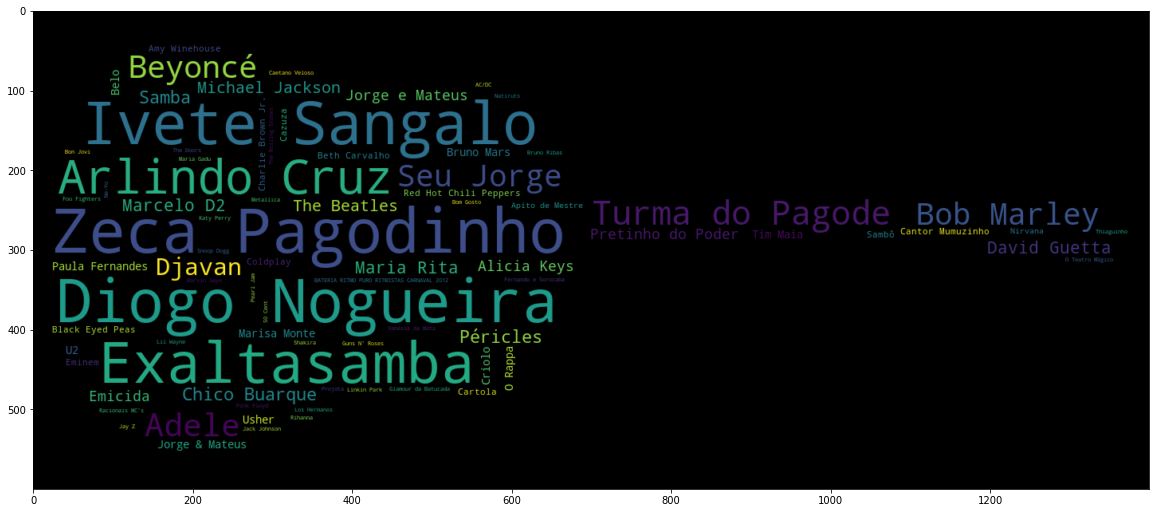

In [ ]:
plt.figure(figsize=(20,10))
default_colors = wc.to_array()
plt.imshow(wc.recolor(random_state=3),interpolation="bilinear")
plt.show()

## **Dataset Creation**

In [ ]:
top_music_list = music_df['page'][:80].values

In [ ]:
uid_map = {k:v for k, v in enumerate(dict_all_friend)}
uid_inv_map = {v:k for k, v in uid_map.items()}
music_map = {k:v for k, v in enumerate(top_music_list)}
music_inv_map = {v:k for k, v in music_map.items()}
music_count = {}

In [ ]:
data = np.zeros((len(uid_inv_map), len(music_inv_map)), np.float64)
for u, m_list in dict_all_friend.items():
  for m in m_list:
    if m not in music_inv_map:
      continue
    data[uid_inv_map[u], music_inv_map[m]] = 1

In [ ]:
df_data = pd.DataFrame(data, columns=np.array([music_map[i] for i in range(max(music_map)+1)]))

Creating dataset in a shape of user X music pages, in order to apply dimension reduction and clustering techniques.

In [ ]:
df_data

,Zeca Pagodinho,Diogo Nogueira,Ivete Sangalo,Exaltasamba,Arlindo Cruz,Turma do Pagode,Adele,Beyoncé,Bob Marley,Seu Jorge,Djavan,Chico Buarque,Péricles,Samba,Maria Rita,David Guetta,Marcelo D2,The Beatles,Michael Jackson,Jorge e Mateus,Emicida,Pretinho do Poder,Alicia Keys,Jorge & Mateus,U2,Tim Maia,Paula Fernandes,Marisa Monte,Criolo,O Rappa,Belo,Usher,Bruno Mars,Red Hot Chili Peppers,Sambô,Cartola,Black Eyed Peas,Coldplay,Eminem,Amy Winehouse,Cantor Mumuzinho,Beth Carvalho,Cazuza,Charlie Brown Jr.,Apito de Mestre,Nirvana,BATERIA RITMO PURO RITMISTAS CARNAVAL 2012,Thiaguinho,Los Hermanos,AC/DC,Foo Fighters,Guns N' Roses,Pearl Jam,Caetano Veloso,Racionais MC's,Projota,Jack Johnson,Bom Gosto,Jay Z,Lil Wayne,Metallica,The Doors,50 Cent,Bruno Ribas,O Teatro Mágico,Pink Floyd,Linkin Park,Bon Jovi,Vanessa da Mata,Rihanna,Natiruts,Fernando e Sorocaba,Snoop Dogg,Maria Gadu,Shakira,Marvin Gaye,Glamour da Batucada,The Rolling Stones,Katy Perry,Ne-Yo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

# **Dimension Reduction**

## **Number of Dimensions Decision**

First, we'll use SVD with maximum number of dimensions, to select a number of dimensions to reduct.

In [ ]:
svd =  TruncatedSVD(n_components = max(music_map))

In [ ]:
svd.fit(df_data)

TruncatedSVD(algorithm='randomized', n_components=79, n_iter=5,
             random_state=None, tol=0.0)

In [ ]:
#Explained variance of each dimension
svd.explained_variance_ratio_.round(2)

array([0.16, 0.08, 0.04, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  ])

Generating the accumulated of explained variance ratio.

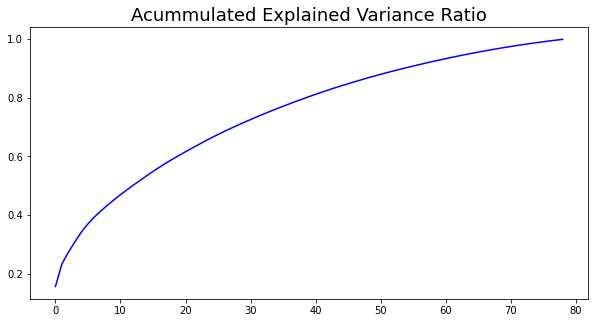

In [ ]:
explained_variance_ratio_acum_ = list([(i-1, svd.explained_variance_ratio_[:i].sum()) for i in range(1, max(music_map)+1)])
plt.figure(figsize=(10,5))
plt.plot([i for i, r in explained_variance_ratio_acum_], [r for i, r in explained_variance_ratio_acum_], 'b')
plt.title('Acummulated Explained Variance Ratio', fontsize=18); 
plt.show()

As we can see in the follwing cell, 12 dimensions capture 50% of explained variance of all 80 variables (music pages).

In [ ]:
pd.DataFrame(explained_variance_ratio_acum_, columns=['variable_index', 'explained_variance_ratio_acum']).head(20)

,variable_index,explained_variance_ratio_acum
0,0,0.158063
1,1,0.234723
2,2,0.274527
3,3,0.309818
4,4,0.343457
5,5,0.370636
6,6,0.394335
7,7,0.414910
8,8,0.434078
9,9,0.452148


## **Truncated SVD**

We'll truncate the number of dimensions in 12.

In [ ]:
svd =  TruncatedSVD(n_components = 12)
svd.fit(df_data)

TruncatedSVD(algorithm='randomized', n_components=12, n_iter=5,
             random_state=None, tol=0.0)

In [ ]:
svd.components_.shape

(12, 80)

In [ ]:
scaler = StandardScaler()

Transforming the original dataset with 80 observed variables, in order to get a new one with only 12 latent variables (dimensions).

In [ ]:
df_data_new = svd.fit_transform(df_data)
df_data_new = scaler.fit_transform(df_data_new)
df_data_new = pd.DataFrame(df_data_new, columns=['Dim' + str(c + 1) for c in range(svd.components_.shape[0])])

### **Users Plot on First 2 Dimensions**

The first 2 dimensions capture 23% of explained variance. In the following graphs we can observe the plot of users in the 2 first dimensions coordenates.

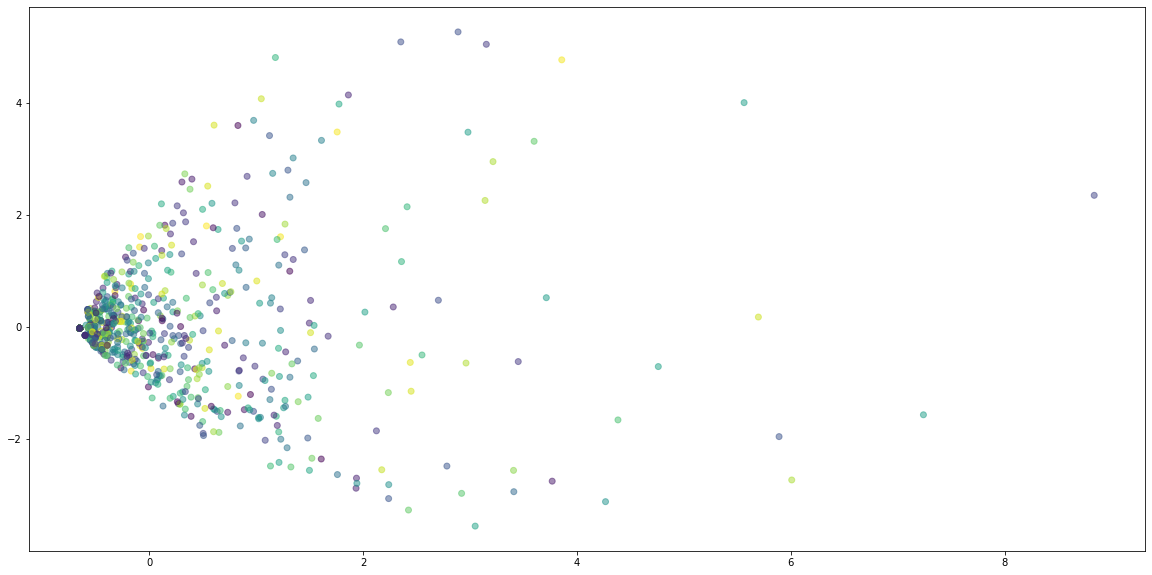

In [ ]:
N = 50
x = df_data_new.Dim1.values
y = df_data_new.Dim2.values
colors = np.random.rand(len(x))

plt.figure(figsize=(20,10))
plt.scatter(x, y, c=colors, alpha=0.5)
plt.show()

### **Music Pages Plot on First 2 Dimensions**

Similar as seen above, in the following graph we can note the plot of music pages on first 2 dimensions coordenates.

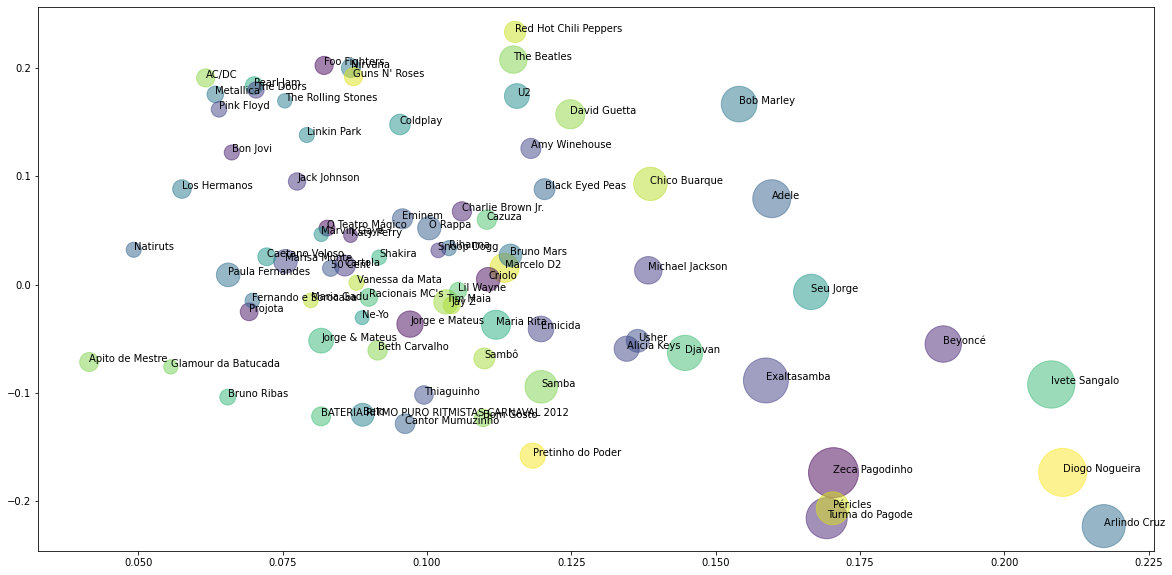

In [ ]:
N = 50
x = svd.components_[0]
y = svd.components_[1]
colors = np.random.rand(len(x))
area = (50 * music_df[:80]['count'].values / max(music_df[:80]['count'].values))**2  # 0 to 15 point radii

plt.figure(figsize=(20,10))
plt.scatter(x, y, s=area, c=colors, alpha=0.5)

for i, txt in enumerate(music_df[:80]['page']):
    plt.annotate(txt, (x[i], y[i]))

plt.show()

### **Dimensions Profiling**

Sorting the top music pages of each dimension, by weights.

In [ ]:
top_pages_on_dims = [pd.DataFrame(sorted([(music_map[m], c) for m, c in enumerate(svd.components_[c])], key=lambda tup: tup[1])[-10:][::-1], columns=['page', 'weight']) for c in range(svd.components_.shape[0])]

We can observe that **Dimension 1** captures affinity to **Samba and Pagode style** (Arlindo Cruz, Diego Nogueira, Zeca Pagodinho, Péricles, Turma do Pagode e Exaltasamba), as well as it captures some affinity to **Axé and Pop style** (Ivete Sangalo and Beyoncé, two big popular artists). For simplicity reasons, we'll refer to this dimension as **Samba and Pagode Affinity Dimension**.

In [ ]:
top_pages_on_dims[0] # dim1

,page,weight
0,Arlindo Cruz,0.217235
1,Diogo Nogueira,0.210122
2,Ivete Sangalo,0.208149
3,Beyoncé,0.189436
4,Zeca Pagodinho,0.170418
5,Péricles,0.170295
6,Turma do Pagode,0.169236
7,Seu Jorge,0.166552
8,Adele,0.159722
9,Exaltasamba,0.158708


We can observe that **Dimension 2** captures affinity to **Rock Music style**, we'll refer to it as **Rock Music Affinity Dimension**.

In [ ]:
top_pages_on_dims[1] # dim2

,page,weight
0,Red Hot Chili Peppers,0.233433
1,The Beatles,0.207898
2,Foo Fighters,0.202477
3,Nirvana,0.200148
4,Guns N' Roses,0.192094
5,AC/DC,0.190937
6,Pearl Jam,0.183816
7,The Doors,0.179785
8,Metallica,0.175758
9,U2,0.174229


We can observe that **Dimension 3** captures affinity to **Classical Samba and MPB style** (Chico Buarque, Tim Maia, Djavan, Cartola, Maria Rita, Marisa Monte), we'll refer to it as **Classical Samba and MPB Affinity Dimension**.

In [ ]:
top_pages_on_dims[2] # dim3

,page,weight
0,Chico Buarque,0.252564
1,Tim Maia,0.198140
2,Djavan,0.195965
3,Cartola,0.190497
4,Maria Rita,0.190320
5,Samba,0.182974
6,Zeca Pagodinho,0.168056
7,Criolo,0.159772
8,Marisa Monte,0.155881
9,Marvin Gaye,0.143010


We can observe that **Dimension 4** captures affinity to more diverse styles, like **Sertanejo** (Jorge e Mateus, Fernando e Sorocaba, Paula Fernandes), **Axé** (Ivete Sangalo), **Rock** (The Beatles, U2), we'll refer to this dimension as **Sertanejo, Axé and Rock Affinity Dimension**.

In [ ]:
top_pages_on_dims[3] # dim4

,page,weight
0,Ivete Sangalo,0.330010
1,Jorge & Mateus,0.253732
2,Jorge e Mateus,0.251318
3,Diogo Nogueira,0.250797
4,Fernando e Sorocaba,0.177599
5,The Beatles,0.157092
6,Paula Fernandes,0.120827
7,U2,0.117750
8,Sambô,0.105092
9,Chico Buarque,0.096631


We can observe that **Dimension 5** captures affinity to very ecletic styles, we can note **Reggae** (Bob Marley), **Pagode** (Péricles, Turma do Pagode), **Rock** (Nirvana, The Doors, Metallica), **Urban** (Marcelo D2, O Rappa) and **Samba** (Arlindo Cruz) styles, we'll refer to this dimension as **Ecletic: Reggae, Pagode, Samba, Rock and Urban Affinity Dimension**.

In [ ]:
top_pages_on_dims[4] # dim5

,page,weight
0,Bob Marley,0.240080
1,Péricles,0.179989
2,Pretinho do Poder,0.160057
3,Nirvana,0.159813
4,Turma do Pagode,0.159118
5,Marcelo D2,0.157690
6,O Rappa,0.157473
7,The Doors,0.148933
8,Arlindo Cruz,0.147082
9,Metallica,0.143373


We can observe that **Dimension 6** captures affinity to **Urban and Rap style** (O Rappa, Marcelo D2, Charlie Brown Jr, Racionais MC's, Criolo, Emicida, Projota), we'll refer to it as **Urban and Rap Affinity Dimension**.

In [ ]:
top_pages_on_dims[5] # dim6

,page,weight
0,O Rappa,0.265768
1,Marcelo D2,0.259269
2,Charlie Brown Jr.,0.237589
3,Bob Marley,0.164792
4,Sambô,0.160649
5,Racionais MC's,0.159064
6,Criolo,0.157968
7,Emicida,0.142025
8,Projota,0.124321
9,David Guetta,0.119801


We can observe that **Dimension 7** also captures affinity to diverse styles, but we can outline **Pagode** (Turma do Pagode, Cantor Mumuzinho, Thiaguinho, Bom Gosto), **MPB** (Chico Buarque, Marisa Monte) and **Rap** (Criolo, Emicida), we'll refer to this dimension as **Pagode, MPB and Rap Affinity Dimension**.

In [ ]:
top_pages_on_dims[6] # dim7

,page,weight
0,Turma do Pagode,0.253058
1,Pretinho do Poder,0.218235
2,Cantor Mumuzinho,0.185993
3,Chico Buarque,0.175871
4,Criolo,0.170022
5,Amy Winehouse,0.168990
6,Marisa Monte,0.152846
7,Emicida,0.141372
8,Thiaguinho,0.140737
9,Bom Gosto,0.139691


From **Dimension 8 to 12**, it starts not getting so clear to identify and name the styles. We'll refer this dimensions only as its numbers.

**Dimension 8**

In [ ]:
top_pages_on_dims[7] # dim8

,page,weight
0,Adele,0.479083
1,Arlindo Cruz,0.255233
2,Cazuza,0.198628
3,Charlie Brown Jr.,0.180872
4,The Beatles,0.175049
5,Bruno Mars,0.151319
6,BATERIA RITMO PURO RITMISTAS CARNAVAL 2012,0.148008
7,Pretinho do Poder,0.128652
8,Bruno Ribas,0.115974
9,Turma do Pagode,0.112964


**Dimension 9**

In [ ]:
top_pages_on_dims[8] # dim9

,page,weight
0,Seu Jorge,0.309677
1,Jorge e Mateus,0.228230
2,David Guetta,0.215215
3,Fernando e Sorocaba,0.157021
4,Jorge & Mateus,0.148496
5,Exaltasamba,0.141413
6,Djavan,0.132928
7,Diogo Nogueira,0.131109
8,Michael Jackson,0.127650
9,Arlindo Cruz,0.103858


**Dimension 10**

In [ ]:
top_pages_on_dims[9] # dim10

,page,weight
0,Diogo Nogueira,0.285145
1,Adele,0.180803
2,Pretinho do Poder,0.161581
3,Bob Marley,0.154017
4,Ivete Sangalo,0.136929
5,Alicia Keys,0.107989
6,O Rappa,0.104267
7,Beyoncé,0.102199
8,Maria Gadu,0.091805
9,Maria Rita,0.090035


**Dimension 11**

In [ ]:
top_pages_on_dims[10] # dim11

,page,weight
0,Samba,0.346991
1,Seu Jorge,0.322631
2,Beyoncé,0.218195
3,AC/DC,0.177673
4,Emicida,0.160938
5,Adele,0.160733
6,Foo Fighters,0.155049
7,Nirvana,0.140286
8,O Rappa,0.133560
9,Jorge e Mateus,0.126695


**Dimension 12**

In [ ]:
top_pages_on_dims[11] # dim12

,page,weight
0,Diogo Nogueira,0.165914
1,Sambô,0.159816
2,Coldplay,0.158272
3,Lil Wayne,0.152142
4,Arlindo Cruz,0.145752
5,Bon Jovi,0.136622
6,Projota,0.135431
7,Paula Fernandes,0.133978
8,Eminem,0.127782
9,Usher,0.126744


Renaming dimension (1 to 7) names.

In [ ]:
df_data_new.columns

Index(['Dim1', 'Dim2', 'Dim3', 'Dim4', 'Dim5', 'Dim6', 'Dim7', 'Dim8', 'Dim9',
       'Dim10', 'Dim11', 'Dim12'],
      dtype='object')

In [ ]:
dict_new_names = {"Dim1": "Samba and Pagode Affinity Dimension",
                   "Dim2": "Rock Music Affinity Dimension",
                   "Dim3": "Classical Samba and MPB Affinity Dimension",
                   "Dim4": "Sertanejo, Axé and Rock Affinity Dimension",
                   "Dim5": "Ecletic: Reggae, Pagode, Samba, Rock and Urban Affinity Dimension",
                   "Dim6": "Urban and Rap Affinity Dimension",
                   "Dim7": "Pagode, MPB and Rap Affinity Dimension"}
df_data_new = df_data_new.rename(columns=dict_new_names)

In [ ]:
df_data_new

,Samba and Pagode Affinity Dimension,Rock Music Affinity Dimension,Classical Samba and MPB Affinity Dimension,"Sertanejo, Axé and Rock Affinity Dimension","Ecletic: Reggae, Pagode, Samba, Rock and Urban Affinity Dimension",Urban and Rap Affinity Dimension,"Pagode, MPB and Rap Affinity Dimension",Dim8,Dim9,Dim10,Dim11,Dim12
0,-0.432739,0.701025,-0.080200,-0.050831,0.696476,-0.424602,-0.097753,-0.060608,-0.315602,0.147067,0.379308,0.205217
1,-0.651282,-0.018121,0.026446,-0.100822,-0.012887,0.051598,0.054541,-0.024727,0.033957,0.031534,-0.055379,0.119764
2,-0.352995,-0.004659,0.035425,-0.852674,-0.315826,-0.539072,0.173096,-0.382872,0.342785,-0.446830,-1.173614,0.561146
3,0.424863,-0.742613,-0.523224,-0.733923,-0.631901,0.400829,-0.920270,-0.784905,-2.295265,-0.374697,0.790838,1.647351
4,-0.322031,0.640279,0.352218,-0.020739,0.504448,-0.009574,-0.006901,-0.075201,-0.261630,-0.013851,-1.223447,-2.082572
...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.520213,-1.450274,-1.739932,-0.555040,2.299110,-0.670275,2.585674,1.056278,-0.775039,-0.808916,-1.649986,1.041993
939,1.208604,-0.375728,3.060188,-1.966719,1.876551,2.671947,-2.148584,-0.343428,-0.324041,0.318916,-1.808787,-0.772211
940,-0.222764,-0.641908,0.650607,0.076864,0.352937,-0.289641,-1.543510,1.274781,0.299060,0.151675,-0.681714,0.529155
941,1.508431,-0.095801,1.834182,-0.281802,2.412737,1.076442,-0.380198,-1.413602,1.661250,1.931586,-1.152892,-0.139284


# **Clustering**

We'll make cluster analysis in 2 steps, the first with the application of **hierarquical cluster**, to determine the ideal number of clusters (k), following with the application of **k-means**, using the selected number of clusters (k).

## **Hierarquical Clustering**

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

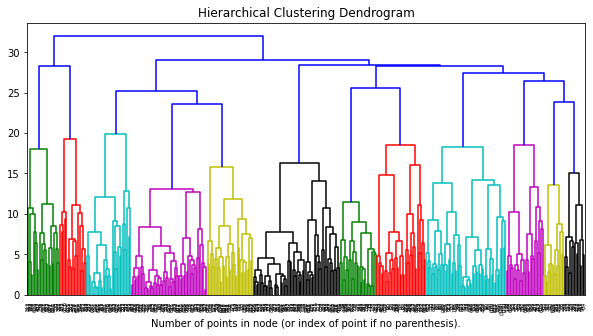

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')

model = model.fit(df_data_new)
plt.figure(figsize=(10,5))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

We considered 5 as good number of clusters to our dataset.

## **K-Means**

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(df_data_new)

In [ ]:
df_cluster_data = pd.concat([df_data_new, pd.Series(kmeans.predict(df_data_new), name='cluster')], axis=1)

## **Clusters Profiling**

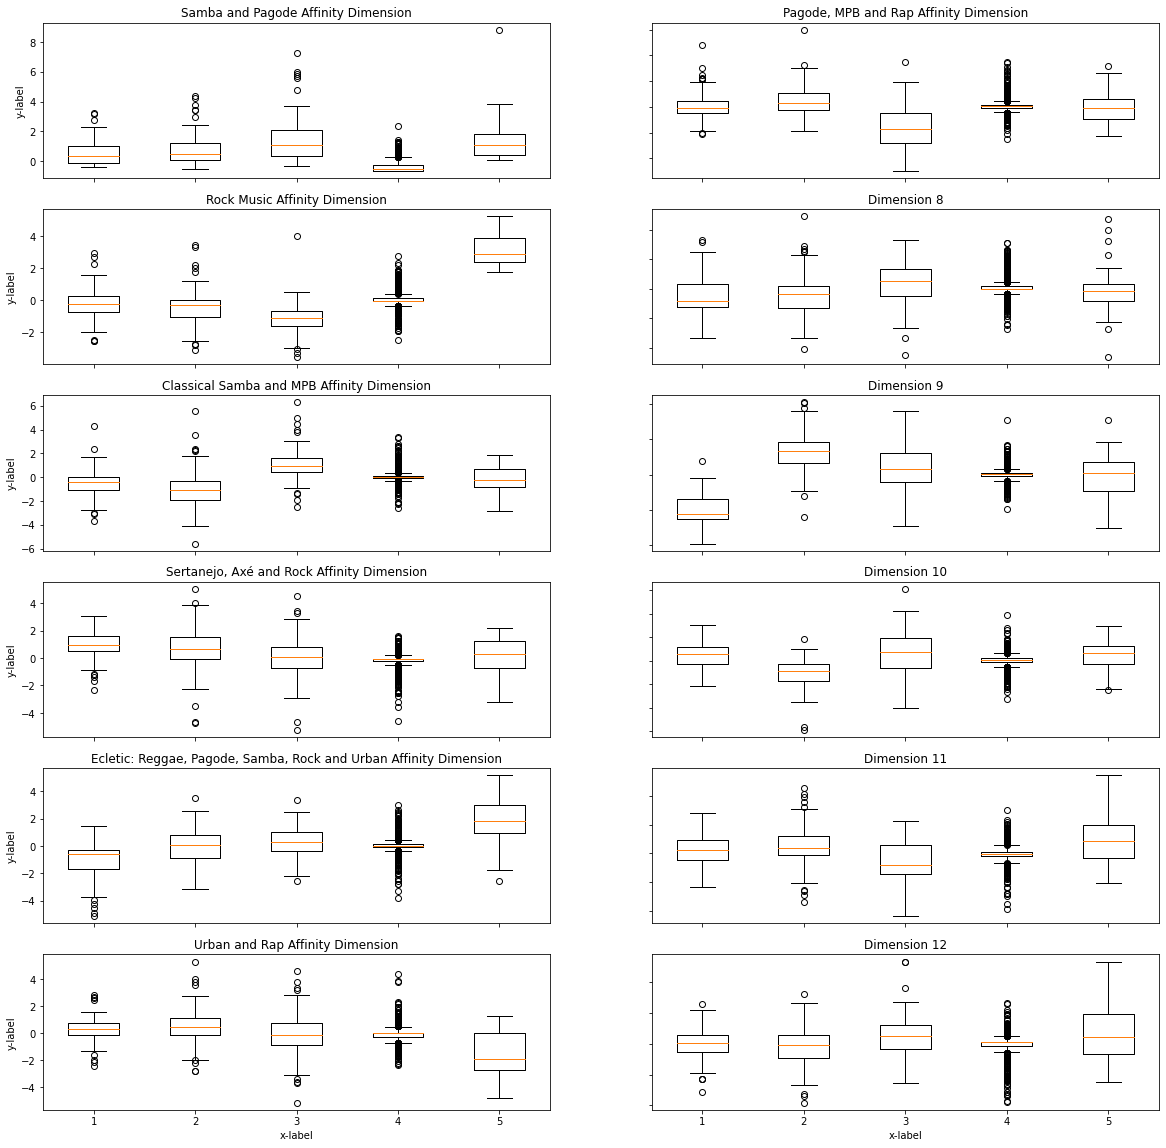

In [ ]:
fig, axs = plt.subplots(6, 2,figsize=(20,20))
for i in range(12):
  columns = dict_new_names['Dim{}'.format(i+1)] if 'Dim{}'.format(i+1) in dict_new_names else 'Dim{}'.format(i+1)
  data = [df_cluster_data[df_cluster_data['cluster']==c][columns].values for c in np.unique(df_cluster_data['cluster'].values)]
  axs[i if i < 6 else i - 6, i // 6].boxplot(data)
  axs[i if i < 6 else i - 6, i // 6].set_title(dict_new_names['Dim{}'.format(i+1)] if 'Dim{}'.format(i+1) in dict_new_names else 'Dimension {}'.format(i + 1))

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()

In [ ]:
df_cluster_data['cluster'].value_counts().sort_index()

0     78
1     85
2     71
3    679
4     30
Name: cluster, dtype: int64

In [ ]:
df_cluster_data['cluster'] = df_cluster_data['cluster'].apply(lambda x: x + 1) #change cluster to star with 1

In [ ]:
df_cluster_data.groupby('cluster').aggregate({dict_new_names['Dim{}'.format(i+1)] if 'Dim{}'.format(i+1) in dict_new_names else 'Dim{}'.format(i+1) : np.mean for i in range(svd.components_.shape[0])})

,Samba and Pagode Affinity Dimension,Rock Music Affinity Dimension,Classical Samba and MPB Affinity Dimension,"Sertanejo, Axé and Rock Affinity Dimension","Ecletic: Reggae, Pagode, Samba, Rock and Urban Affinity Dimension",Urban and Rap Affinity Dimension,"Pagode, MPB and Rap Affinity Dimension",Dim8,Dim9,Dim10,Dim11,Dim12
cluster,,,,,,,,,,,,
1,0.548991,-0.214407,-0.504619,0.910466,-1.000385,0.291626,0.109067,-0.501567,-2.014069,0.469036,0.252476,-0.117252
2,0.758719,-0.437479,-0.955882,0.635486,-0.035497,0.581522,0.476819,-0.388543,1.337296,-1.066195,0.508274,-0.160324
3,1.509835,-1.162816,1.116762,-0.061875,0.284636,-0.051332,-1.587355,0.369755,0.324664,0.508191,-0.507176,0.522551
4,-0.383781,0.059006,0.067842,-0.190720,0.011382,-0.031147,0.093161,0.071200,0.037141,0.008455,-0.085713,-0.044443
5,1.535881,3.213479,-0.158141,0.295306,1.770325,-1.579434,0.013645,-0.081637,-0.161413,0.407302,1.043742,0.528297


As observed at the most liked music pages in **Cluster 1**, it reunites who has affinity with different styles like **Axé, Pop, MPB, Pagode and Samba**.

In [ ]:
cluster = 1
print('*** Cluster {} ***'.format(cluster))
print()
print(df_data[df_cluster_data['cluster'] == cluster].sum().sort_values(ascending=False)[:10])
print()
print('Avg Likes per User: {}'.format(df_data[df_cluster_data['cluster'] == cluster].sum().sum() / df_data[df_cluster_data['cluster'] == cluster].shape[0]))

*** Cluster 1 ***

Ivete Sangalo      78.0
Adele              20.0
Diogo Nogueira     19.0
Turma do Pagode    15.0
Beyoncé            15.0
Chico Buarque      14.0
Péricles           13.0
Exaltasamba        13.0
Rihanna            12.0
Samba              12.0
dtype: float64

Avg Likes per User: 7.461538461538462


In **Cluster 2** we can observe users who has more affinity to **Sertanejo, Samba and Pagode Style**.

In [ ]:
cluster = 2
print('*** Cluster {} ***'.format(cluster))
print()
print(df_data[df_cluster_data['cluster'] == cluster].sum().sort_values(ascending=False)[:10])
print()
print('Avg Likes per User: {}'.format(df_data[df_cluster_data['cluster'] == cluster].sum().sum() / df_data[df_cluster_data['cluster'] == cluster].shape[0]))

*** Cluster 2 ***

Jorge e Mateus         53.0
Jorge & Mateus         33.0
Seu Jorge              31.0
Fernando e Sorocaba    30.0
Exaltasamba            27.0
Diogo Nogueira         22.0
Arlindo Cruz           22.0
Turma do Pagode        22.0
Beyoncé                20.0
Péricles               19.0
dtype: float64

Avg Likes per User: 9.564705882352941


**Cluster 3** clearly reunites who has more affinity to **Samba and Pagode Style**.

In [ ]:
cluster = 3
print('*** Cluster {} ***'.format(cluster))
print()
print(df_data[df_cluster_data['cluster'] == cluster].sum().sort_values(ascending=False)[:10])
print()
print('Avg Likes per User: {}'.format(df_data[df_cluster_data['cluster'] == cluster].sum().sum() / df_data[df_cluster_data['cluster'] == cluster].shape[0]))

*** Cluster 3 ***

Zeca Pagodinho                                59.0
Arlindo Cruz                                  58.0
Diogo Nogueira                                42.0
Beth Carvalho                                 29.0
Péricles                                      27.0
Samba                                         26.0
Exaltasamba                                   21.0
Djavan                                        21.0
Ivete Sangalo                                 21.0
BATERIA RITMO PURO RITMISTAS CARNAVAL 2012    19.0
dtype: float64

Avg Likes per User: 13.80281690140845


**Cluster 4** is the one with majority of users. It doesn't seem very clear the preferential style. Observing the average number of likes per user, we can infer that this is the group of users not engaged to provide likes to Facebook pases 

In [ ]:
cluster = 4
print('*** Cluster {} ***'.format(cluster))
print()
print(df_data[df_cluster_data['cluster'] == cluster].sum().sort_values(ascending=False)[:10])
print()
print('Avg Likes per User: {}'.format(df_data[df_cluster_data['cluster'] == cluster].sum().sum() / df_data[df_cluster_data['cluster'] == cluster].shape[0]))

*** Cluster 4 ***

Bob Marley           50.0
Adele                37.0
The Beatles          33.0
Michael Jackson      33.0
Beyoncé              32.0
David Guetta         31.0
Apito de Mestre      31.0
Pretinho do Poder    30.0
Chico Buarque        29.0
Criolo               27.0
dtype: float64

Avg Likes per User: 1.9764359351988219


**Cluster 5** strongly reunites people with great affinity to **Rock Style**.

In [ ]:
cluster = 5
print('*** Cluster {} ***'.format(cluster))
print()
print(df_data[df_cluster_data['cluster'] == cluster].sum().sort_values(ascending=False)[:10])
print()
print('Avg Likes per User: {}'.format(df_data[df_cluster_data['cluster'] == cluster].sum().sum() / df_data[df_cluster_data['cluster'] == cluster].shape[0]))

*** Cluster 5 ***

Nirvana                  28.0
Guns N' Roses            23.0
Red Hot Chili Peppers    22.0
AC/DC                    21.0
The Rolling Stones       20.0
Metallica                20.0
The Doors                20.0
Pink Floyd               18.0
Foo Fighters             18.0
Pearl Jam                17.0
dtype: float64

Avg Likes per User: 17.966666666666665
